In [1]:
# numpy and pandas for data manipulation
import sys
# Suppress warnings
import warnings

import matplotlib.pyplot as plt
import networkx as nx

import numpy as np
import pandas as pd

warnings.filterwarnings('ignore')

# matplotlib and seaborn for plotting
import matplotlib.pyplot as plt
%matplotlib inline

ROOT_PACKAGE_DIRECTORY = '/Users/bede01/Documents/work/phd-papers/ml-workload-optimization/code/jupyter'
root_data = ROOT_PACKAGE_DIRECTORY + '/data'


sys.path.append(ROOT_PACKAGE_DIRECTORY)
from experiment_graph.execution_environment import ExecutionEnvironment

## Use Case 1
Here are the steps for the use case 1
1. Load data
2. chain 2 data transformation and a model training
3. store the graph
4. open a new workload
5. load the history graph
6. write the exact same transformations and model training
7. the model should be fetched from the history graph instead being executed

In [2]:
DATABASE_PATH = root_data + '/experiment_graphs/optimizer_test/uc1'

workload graph size: 4
adding (CF2C2612,4B122318) to valid nodes
adding (A2E75CDF,D6374562) to valid nodes
adding (7DEC51E8,437CFCBD) to valid nodes
encountered combine nodes
{}
super nodes after one pass
{}
materialized nodes {'7DEC51E8': '437CFCBD'}
optimized workload graph size: 0


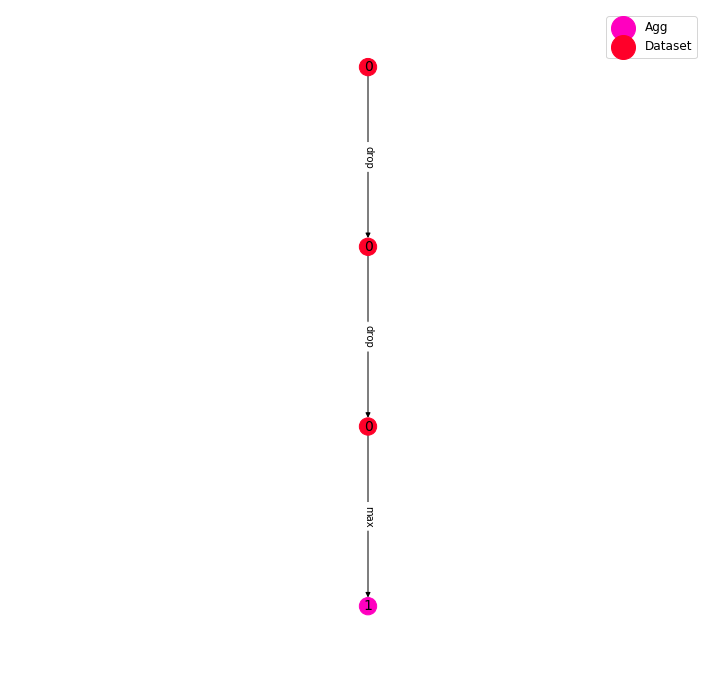

In [3]:
# Simple Case: Chain of 4 operations (No Merge or Branch)

# Create Execution Environment
ee = ExecutionEnvironment('dedup')
# Load Data
train = ee.load(root_data + '/openml/task_id=31/train.csv')

# Transformation 1
train = train.drop(columns=['checking_status'])

# Transformation 2
train = train.drop(columns=['class'])

# Transformation 3
max_cols = train.max()

# Execute
data_main = max_cols.data(verbose = 0)

# Save history graph
ee.save_history(DATABASE_PATH, overwrite=True)
# Plot workload graph
ee.workload_graph.plot_graph(plt, edge_oper=True)


######### NEW WORKLOAD ############

# Create new environment
ee_2 = ExecutionEnvironment('dedup')
# Load the history graph
ee_2.load_history(DATABASE_PATH)
# Simple Case: Chain of 4 operations

# Load Data
train = ee_2.load(root_data + '/openml/task_id=31/train.csv')

# Transformation 1
train = train.drop(columns=['checking_status'])

# Transformation 2
train = train.drop(columns=['class'])

# Transformation 3
max_cols = train.max()

# Execute
data_second_workload = max_cols.data(verbose = 1)

del ee
del ee_2

workload graph size: 6
optimized workload graph size: 6
/Users/bede01/Documents/work/phd-papers/ml-workload-optimization/code/jupyter/data/openml/task_id=31/train.csv--drop({'columns':['checking_status']})->3C59FDA4
3C59FDA4--drop({'columns':['class']})->AFAD2402
AFAD2402--fit_sk_model({'model':MinMaxScaler(copy=True,feature_range=(0,1))})->B5DA1114
B5DA1114AFAD2402--transform({})->2AC35E3A


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.0s finished


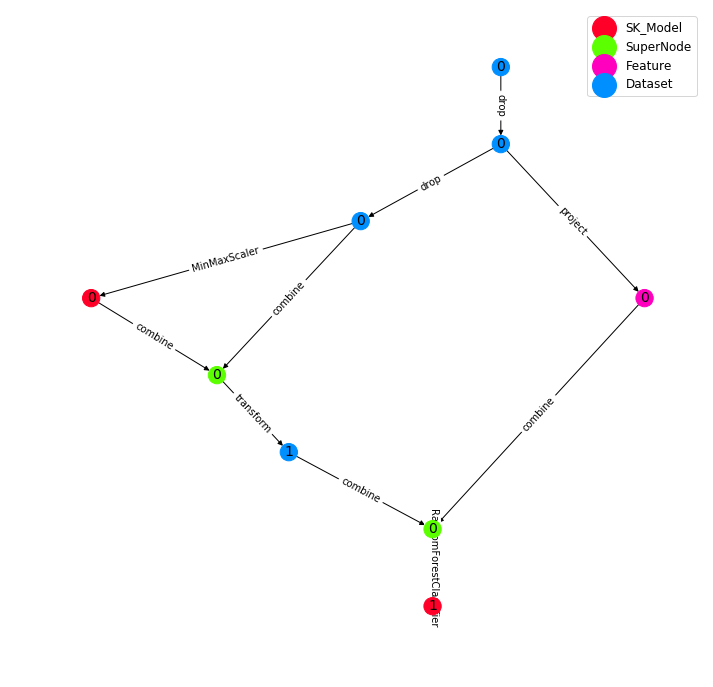

In [4]:
# Use Case: Chain of 3 Transformations and 1 Model Building (includes two merges in total)
# Create Execution Environment
ee = ExecutionEnvironment('dedup')

# Load Data
train = ee.load(root_data + '/openml/task_id=31/train.csv')

# Transformation 1
train = train.drop(columns=['checking_status'])

# Transformation 2
train_labels = train['class']
train = train.drop(columns=['class'])

# Transformation 3
from experiment_graph.sklearn_helper.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
scaler.fit(train)
train = scaler.transform(train)
data = train.data(verbose=1)

# Model Training
from experiment_graph.sklearn_helper.ensemble import RandomForestClassifier
random_forest = RandomForestClassifier(n_estimators=10, random_state=50, verbose=1, n_jobs=-1)
random_forest.fit(train, train_labels)

# Execute
random_forest.trained_node.data()

# Save history graph
ee.save_history(DATABASE_PATH, overwrite=True)
# Plot workload graph
ee.workload_graph.plot_graph(plt, edge_oper=True)

In [5]:
ee_2 = ExecutionEnvironment('dedup')
ee_2.load_history(DATABASE_PATH)

In [6]:
# Load Data
train = ee_2.load(root_data + '/openml/task_id=31/train.csv')

# Transformation 1
train = train.drop(columns=['checking_status'])

# Transformation 2
train_labels = train['class']
train = train.drop(columns=['class'])

# Transformation 3
from experiment_graph.sklearn_helper.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
scaler.fit(train)
train = scaler.transform(train)

# Model Training
from experiment_graph.sklearn_helper.ensemble import RandomForestClassifier
random_forest = RandomForestClassifier(n_estimators=10, random_state=50, verbose=1, n_jobs=-1)
random_forest.fit(train, train_labels)

# Execute
random_forest.trained_node.data(verbose=1)

workload graph size: 9
adding (D65135C5,3C59FDA4) to valid nodes
adding (2F957118,E7993959) to valid nodes
adding (3BB141BD,AFAD2402) to valid nodes
adding (2CC440EC,B5DA1114) to valid nodes
encountered combine nodes
{'80B0364D2F957118': set([('2F957118', 'E7993959')]), '2CC440EC3BB141BD': set([('2CC440EC', 'B5DA1114'), ('3BB141BD', 'AFAD2402')])}
super nodes after one pass
{'2CC440EC3BB141BD': set([('3BB141BD', 'AFAD2402'), ('2CC440EC', 'B5DA1114')])}
encountered combine nodes
{'80B0364D2F957118': set([('2F957118', 'E7993959'), ('80B0364D', '2AC35E3A')]), '2CC440EC3BB141BD': set([('2CC440EC', 'B5DA1114'), ('3BB141BD', 'AFAD2402')])}
super nodes after one pass
{'80B0364D2F957118': set([('2F957118', 'E7993959'), ('80B0364D', '2AC35E3A')])}
encountered combine nodes
{'80B0364D2F957118': set([('2F957118', 'E7993959'), ('80B0364D', '2AC35E3A')]), '2CC440EC3BB141BD': set([('2CC440EC', 'B5DA1114'), ('3BB141BD', 'AFAD2402')])}
super nodes after one pass
{}
materialized nodes {'9E1668AE': '57F

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
            oob_score=False, random_state=50, verbose=1, warm_start=False)

In [7]:
ee_2.workload_graph.graph.nodes(data=True)

NodeDataView({'2CC440EC3BB141BD': {'type': 'SuperNode', 'involved_nodes': ['2CC440EC', '3BB141BD'], 'data': <experiment_graph.execution_environment.SuperNode object at 0x10a156750>, 'root': False, 'size': 0.0}, '80B0364D': {'root': False, 'size': 0.0, 'type': 'Dataset', 'data': <experiment_graph.execution_environment.Dataset object at 0x10a1566d0>}, 'D65135C5': {'root': False, 'size': 0.0, 'type': 'Dataset', 'data': <experiment_graph.execution_environment.Dataset object at 0x1032ea890>}, '2CC440EC': {'root': False, 'size': 0.0, 'type': 'SK_Model', 'data': <experiment_graph.execution_environment.SK_Model object at 0x10a156690>}, '/Users/bede01/Documents/work/phd-papers/ml-workload-optimization/code/jupyter/data/openml/task_id=31/train.csv': {'type': 'Dataset', 'size': 0.14563751220703125, 'root': True, 'data': <experiment_graph.execution_environment.Dataset object at 0x10a0f9c90>, 'loc': '/Users/bede01/Documents/work/phd-papers/ml-workload-optimization/code/jupyter/data/openml/task_id=3

In [8]:
ee_2.workload_graph.graph.edges(data=True)

OutEdgeDataView([('2CC440EC3BB141BD', '80B0364D', {'oper': 'p_transform', 'hash': 'transform({})', 'name': 'transform', 'execution_time': -1, 'freq': 1, 'args': {}}), ('80B0364D', '80B0364D2F957118', {'oper': 'combine', 'hash': "combine({'c_oper':'fit_sk_model_with_labels'})", 'name': 'combine', 'execution_time': 0, 'freq': 1, 'args': {'c_oper': 'fit_sk_model_with_labels'}}), ('D65135C5', '2F957118', {'oper': 'p_project', 'hash': "project({'columns':'class'})", 'name': 'project', 'execution_time': -1, 'freq': 1, 'args': {'columns': 'class'}}), ('D65135C5', '3BB141BD', {'oper': 'p_drop', 'hash': "drop({'columns':['class']})", 'name': 'drop', 'execution_time': -1, 'freq': 1, 'args': {'columns': ['class']}}), ('2CC440EC', '2CC440EC3BB141BD', {'oper': 'combine', 'hash': "combine({'c_oper':'transform'})", 'name': 'combine', 'execution_time': 0, 'freq': 1, 'args': {'c_oper': 'transform'}}), ('/Users/bede01/Documents/work/phd-papers/ml-workload-optimization/code/jupyter/data/openml/task_id=31

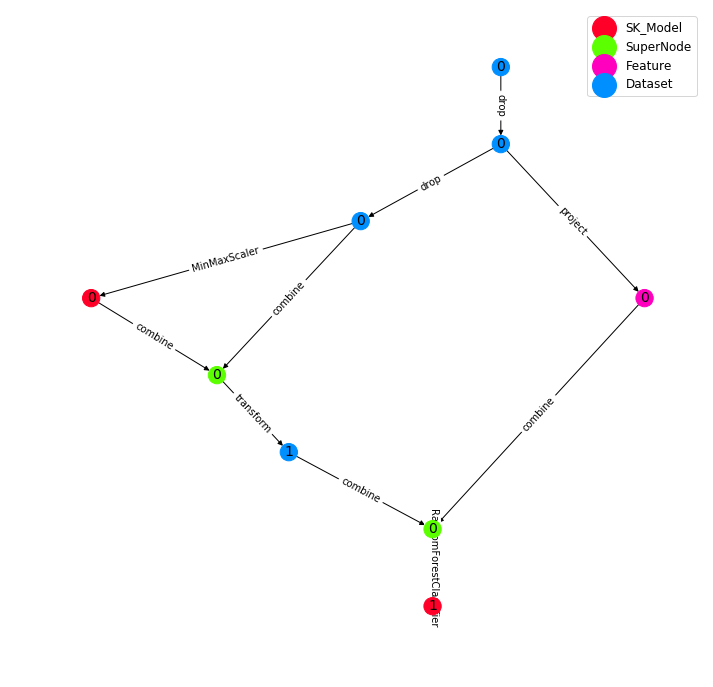

In [9]:
ee_2.history_graph.plot_graph(plt, edge_oper=True)